In [1]:
%matplotlib inline

import numpy as np
import torch
import matplotlib.pyplot as plt

## Define the Generator class for model loading

In [2]:
import torch.nn as nn
import torch.nn.functional as F

class Generator(nn.Module):

    def __init__(self, input_size, hidden_dim, output_size):
        super(Generator, self).__init__()
        
        # define hidden linear layers
        self.fc1 = nn.Linear(input_size, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim*2)
        self.fc3 = nn.Linear(hidden_dim*2, hidden_dim*4)
        
        # final fully-connected layer
        self.fc4 = nn.Linear(hidden_dim*4, output_size)
        
        # dropout layer 
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        # all hidden layers
        x = F.leaky_relu(self.fc1(x), 0.2) # (input, negative_slope=0.2)
        x = self.dropout(x)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = self.dropout(x)
        x = F.leaky_relu(self.fc3(x), 0.2)
        x = self.dropout(x)
        
        # final layer with tanh applied. We normalize the images between -1 and 1 using tanh.
        out = F.tanh(self.fc4(x))

        return out

In [3]:
# Generator hyperparams

# Size of latent vector to give to generator
z_size = 100
# Size of discriminator output (generated image)
g_output_size = 784 # 28*28
# Size of first hidden layer in the generator
g_hidden_size = 32

## Load the saved model

In [4]:
G = Generator(z_size, g_hidden_size, g_output_size)

In [5]:
G.load_state_dict(torch.load('generator.pth'))

<All keys matched successfully>

In [6]:
G.eval()

Generator(
  (fc1): Linear(in_features=100, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=784, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)

## Explore the latent space

Here we generate random points in latent space first and then interpolate them using linear interpolation.

In [7]:
# generate points in latent space as input for the generator
def generate_latent_points(sample_size):
    # generate points in the latent space
    z_input = np.random.uniform(-1, 1, size=(sample_size, z_size)) # z_size = 100, latent vector dimensions
    return z_input

In [8]:
# create a plot of generated images
def plot_generated(n_steps, samples):
    fig, axes = plt.subplots(figsize=(10,10), nrows=1, ncols=n_steps, sharey=True, sharex=True)
    # plot images
    for ax, img in zip(axes.flatten(), samples):
        img = img.detach() # we need to detach the image so that it gets out of the computation graph
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((28,28)), cmap='Greys_r')

In [9]:
# uniform interpolation between two points in latent space
def interpolate_points(p1, p2, n_steps=10):
    # interpolate ratios between the points
    # n_steps defines the number of samples to generate while interpolating from p1 to p2.
    ratios = np.linspace(0, 1, num=n_steps)
    # linear interpolate vectors
    vectors = list()
    for ratio in ratios:
        # Mid point of the two points lie when the ratio is 0.5.
        v = (1.0 - ratio) * p1 + ratio * p2
        vectors.append(v)
    return np.asarray(vectors)

### Now we generate points in latent space to interpolate them. 
### Every consecutive pair of points are considered for the interpolation.

In [10]:
# Number of points to generate
n = 2

In [11]:
# Generate latent points
random_latent_points = generate_latent_points(n)

In [12]:
# Check the shape
random_latent_points.shape

(2, 100)

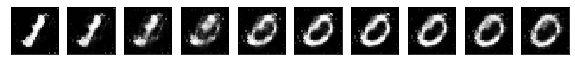

In [14]:
# Interpolate pairs of latent points.
for i in range(0, n, 2):
    # interpolate points in latent space. we consider consecutive latent points for interpolation.
    # n_steps defines the number of samples to generate while interpolating from p1 to p2.
    interpolated = interpolate_points(random_latent_points[i], random_latent_points[i+1], n_steps=10)
    # generate images
    rand_images = G(torch.from_numpy(interpolated).float())
    # plot images
    plot_generated(n_steps=10, samples=rand_images)